In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import fid_custom
from sklearn.manifold import TSNE

In [ ]:
celebA_data = 'celebA_data/celebA_fid_stats.npz'
biased_data = 'biased_datasets/Smiling_Young_Male_99_Not_Male_1_N15000'

def out(mode, k):
    return  f'GANs/gan_chain{mode}/outputs/gan_iter_{k}/features'

real_stats = fid_custom.load_stats(celebA_data)
biased_stats = fid_custom.load_stats(f'{biased_data}/fid_stats.npz')

mu_r, sigma_r, Nr = list(real_stats.values())
mu_g, sigma_g, Ng = list(biased_stats.values())

out_dir_gan = [out('', i) for i in range(1,6)]
out_dir_gan_perc = [out('_perceptual', i) for i in range(1,6)]
out_dir_gan_fid = [out('_fid', i) for i in range(1,6)]

stats_gan = [fid_custom.features_to_stat(f'{biased_data}/features', *out_dir_gan[:i]) for i in range(6)]
stats_gan_perc = [fid_custom.features_to_stat(f'{biased_data}/features', *out_dir_gan_perc[:i]) for i in range(6)]
stats_gan_fid = [fid_custom.features_to_stat(f'{biased_data}/features', *out_dir_gan_fid[:i]) for i in range(6)]

result_gan = [fid_custom.calculate_fid(mu_r, sigma_r, *list(stat.values())[:2]).item() for stat in stats_gan]
result_gan_perc = [fid_custom.calculate_fid(mu_r, sigma_r, *list(stat.values())[:2]).item() for stat in stats_gan_perc]
result_gan_fid = [fid_custom.calculate_fid(mu_r, sigma_r, *list(stat.values())[:2]).item() for stat in stats_gan_fid]

reference = fid_custom.calculate_fid(mu_r, sigma_r, *list(biased_stats.values())[:2])

In [ ]:
def plot_values(data, names, ref_value):

    plt.figure(figsize=(10, 6))
    
    for values, label in zip(data, names):
        plt.plot(values, label=label, marker='o')
    
    plt.axhline(y=ref_value, color='r', linestyle='dotted', label=f"FID of the biased Dataset = {ref_value:.2f}")
    
    plt.xlabel("Iteration")
    plt.ylabel("FID")
    plt.title("Plot of FID score vs GAN iterations")
    plt.legend()
    plt.grid(True)
    plt.savefig('fid.png', dpi=300)
    plt.show()

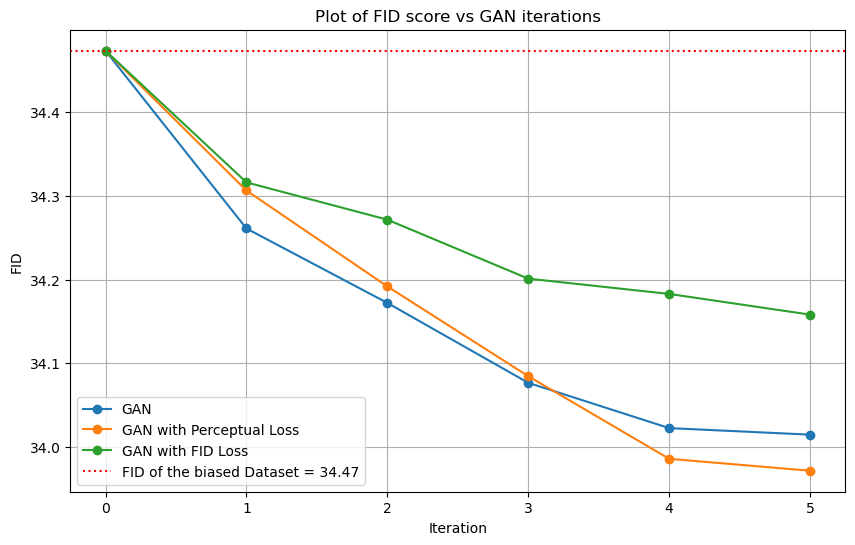

In [20]:
plot_values([result_gan, result_gan_perc, result_gan_fid], ['GAN', 'GAN with Perceptual Loss', 'GAN with FID Loss'], reference)

In [10]:
m_gan = [list(stat.values())[0] for stat in stats_gan]
m_gan_perc = [list(stat.values())[0] for stat in stats_gan_perc]
m_gan_fid = [list(stat.values())[0] for stat in stats_gan_fid]

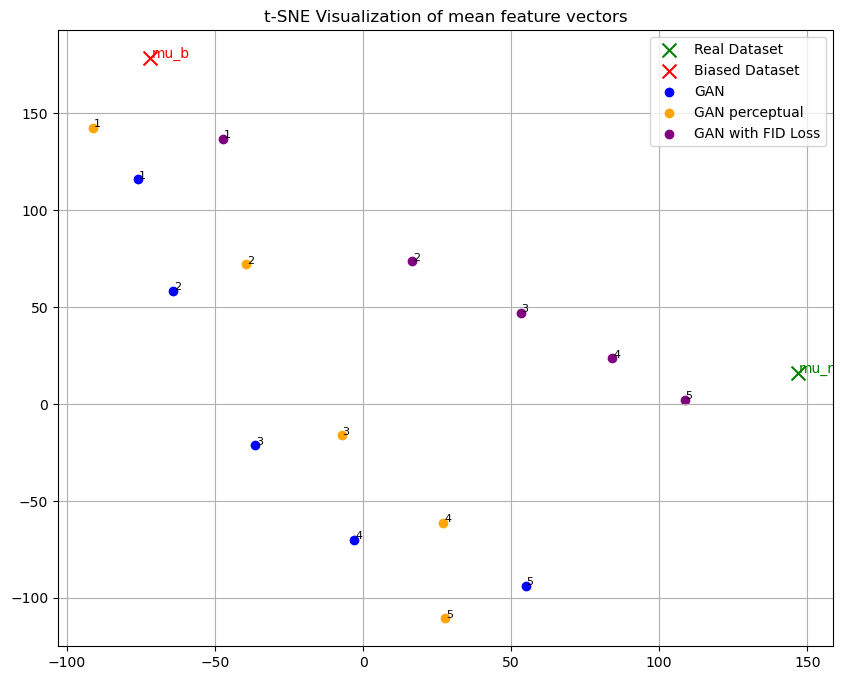

In [67]:
list1 = np.stack(m_gan[1:])  # shape (5, 2048)
list2 = np.stack(m_gan_perc[1:])  # shape (5, 2048)
list3 = np.stack(m_gan_fid[1:])  # shape (5, 2048)

# Stack everything together
all_vectors = np.vstack([mu_r[None, :], mu_g[None, :], list1, list2, list3])

# t-SNE to 2D
tsne = TSNE(n_components=2, perplexity=5, random_state=69)
all_vectors_2d = tsne.fit_transform(all_vectors)

# Flip Y-axis
all_vectors_2d[:, 1] *= -1  # Flip the Y-values

# Indices
i_mu_r = 0
i_mu_g = 1
i_list1 = slice(2, 7)    # indices 2,3,4,5,6
i_list2 = slice(7, 12)   # indices 7,8,9,10,11
i_list3 = slice(12, 17)  # indices 12,13,14,15,16

# Plot
plt.figure(figsize=(10, 8))

# Plot mu_r and mu_g
plt.scatter(*all_vectors_2d[i_mu_r], color='green', marker='x', s=100, label='Real Dataset')
plt.scatter(*all_vectors_2d[i_mu_g], color='red', marker='x', s=100, label='Biased Dataset')
plt.text(all_vectors_2d[i_mu_r,0]+0.5, all_vectors_2d[i_mu_r,1]+0.5, 'mu_r', color='green')
plt.text(all_vectors_2d[i_mu_g,0]+0.5, all_vectors_2d[i_mu_g,1]+0.5, 'mu_b', color='red')

# Colors and lists
colors = ['blue', 'orange', 'purple']
lists = [i_list1, i_list2, i_list3]
listname = ['GAN', 'GAN perceptual', 'GAN with FID Loss']

for idx, (color, indices) in enumerate(zip(colors, lists)):
    points = all_vectors_2d[indices]
    plt.scatter(points[:, 0], points[:, 1], color=color, label= listname[idx])
    for j, (x, y) in enumerate(points):
        plt.text(x + 0.3, y + 0.3, str(j+1), fontsize=8)

plt.legend()
plt.title('t-SNE Visualization of mean feature vectors')
plt.grid(True)
plt.savefig('tsne.png', dpi=300)
plt.show()
